# 1. Import thư viện

In [1]:
import time
import pickle
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping
from keras.preprocessing.text import Tokenizer
from keras.layers import Embedding, Flatten, Dense, concatenate, BatchNormalization
from keras_preprocessing.sequence import pad_sequences

from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [2]:
def read_pickle_file(file_path):
    with open(file_path, 'rb') as file:
        data = pickle.load(file)
    return data

def save_to_pickle_file(data, file_path):
    with open(file_path, 'wb') as file:
        pickle.dump(data, file)

In [3]:
# load file
embedding_model = load_model('../processor/embedding_model.h5')
amenities_tokenizer = read_pickle_file('../processor/amenities_tokenizer.pkl')
dict_label_encoder = read_pickle_file('../processor/dict_label_encoder.pkl')

# 2. Load dữ liệu và tiền xử lý dữ liệu

## 2.1 Load dữ liệu

In [4]:
# load dữ liệu
df_train = pd.read_csv('../dataset preprocessed/data_train.csv')
df_train = df_train.fillna("")

print(df_train.shape)
df_train.head()

(79205, 8)


,bathrooms,bedrooms,square_feet,state,amenities,latitude,longitude,price
0,2.0,2.0,1059,42,"gym,parking,pool,washer dryer",27.7682,-97.4003,1520.0
1,1.0,2.0,800,14,"patio/deck,washer dryer",41.5448,-93.5818,805.0
2,1.0,1.0,765,29,"parking,patio/deck,storage",40.8511,-74.7078,1400.0
3,1.0,1.0,745,12,"dishwasher,doorman,elevator,parking,pool,storage",41.8625,-87.6825,1510.0
4,1.0,1.0,650,5,,39.7436,-105.1080,1485.0


In [5]:
df_test = pd.read_csv('../dataset preprocessed/data_test.csv')
df_test = df_test.fillna("")

print(df_test.shape)
df_test.head()

(19783, 8)


,bathrooms,bedrooms,square_feet,state,amenities,latitude,longitude,price
0,2.0,3.0,1650,32,,35.8230,-78.6438,1395.0
1,1.5,2.0,965,30,,35.1038,-106.6110,1250.0
2,1.5,2.0,872,46,,47.7046,-122.1989,2000.0
3,3.0,3.0,1500,23,,34.3504,-89.5190,1800.0
4,1.0,0.0,290,36,,45.5091,-122.6449,1099.0


## 2.2 Kiểm tra outlier

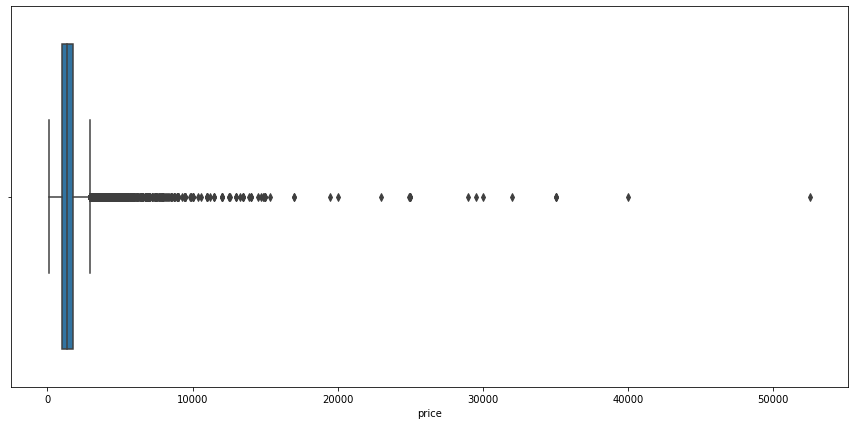

In [6]:
# Vẽ boxplot
plt.figure(figsize=(15, 7))
sns.boxplot(x=df_train['price'])
plt.show()

In [7]:
df_train = df_train[df_train['price'] <= 10000]
df_train

,bathrooms,bedrooms,square_feet,state,amenities,latitude,longitude,price
0,2.0,2.0,1059,42,"gym,parking,pool,washer dryer",27.7682,-97.4003,1520.0
1,1.0,2.0,800,14,"patio/deck,washer dryer",41.5448,-93.5818,805.0
2,1.0,1.0,765,29,"parking,patio/deck,storage",40.8511,-74.7078,1400.0
3,1.0,1.0,745,12,"dishwasher,doorman,elevator,parking,pool,storage",41.8625,-87.6825,1510.0
4,1.0,1.0,650,5,,39.7436,-105.1080,1485.0
...,...,...,...,...,...,...,...,...
79200,1.0,1.0,672,27,"cable or satellite,dishwasher,fireplace,gated,...",39.5197,-119.8342,940.0
79201,1.0,1.0,600,46,"dishwasher,garbage disposal,internet access,pa...",47.4608,-122.2095,1260.0
79202,1.0,2.0,1000,19,parking,38.9993,-76.9750,1540.0
79203,2.0,3.0,1305,8,,28.5964,-81.3237,1795.0


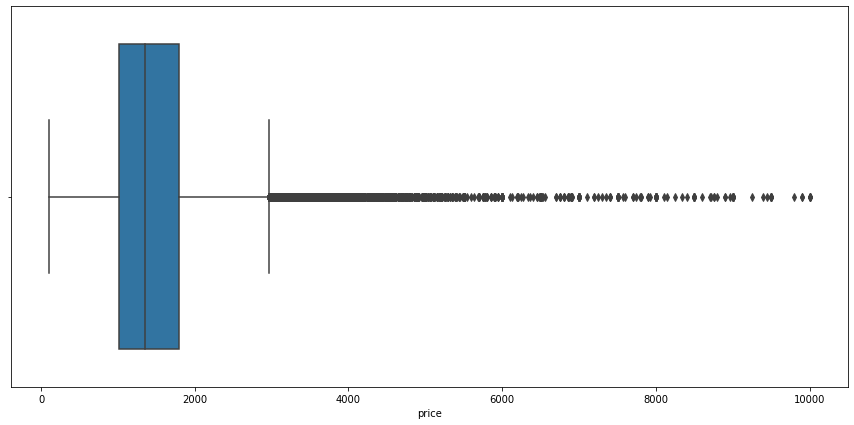

In [8]:
# Vẽ boxplot
plt.figure(figsize=(15, 7))
sns.boxplot(x=df_train['price'])
plt.show()

## 2.4 Embedding cột 'amenities'

In [9]:
vocab_size = amenities_tokenizer['vocab_size']
vocab_size

35

In [10]:
def texts_to_pad_sequences(tokenizer, text):
    sequences = tokenizer.texts_to_sequences(text)
    padded_sequences = pad_sequences(sequences, maxlen=vocab_size)
    return padded_sequences

pad_seq_amenities_train = texts_to_pad_sequences(amenities_tokenizer['tokenizer'], df_train['amenities'])
pad_seq_amenities_test = texts_to_pad_sequences(amenities_tokenizer['tokenizer'], df_test['amenities'])
pad_seq_amenities_train

array([[0, 0, 0, ..., 2, 5, 6],
       [0, 0, 0, ..., 4, 5, 6],
       [0, 0, 0, ..., 1, 4, 7],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 2, 5, 6]])

In [11]:
amenities_embedded_train = embedding_model.predict(pad_seq_amenities_train, verbose=0)
amenities_embedded_test = embedding_model.predict(pad_seq_amenities_test, verbose=0) 

print(len(amenities_embedded_train), len(amenities_embedded_test))
print(amenities_embedded_train[:3])
print(amenities_embedded_test[:3])

79146 19783
[[-0.00631964 -0.03823325 -0.00539724]
 [-0.00978334 -0.03018637 -0.00576684]
 [-0.00890295 -0.05009568 -0.01014743]]
[[ 0.000383   -0.05821197 -0.00443432]
 [ 0.000383   -0.05821197 -0.00443432]
 [ 0.000383   -0.05821197 -0.00443432]]


## 2.5 Kết hợp dữ liệu

In [12]:
# lấy ra các đặc trưng dạng số
num_features = ['bathrooms', 'bedrooms', 'square_feet', 'state', 'latitude', 'longitude']
numerical_features_train = df_train[num_features].values
numerical_features_test = df_test[num_features].values
numerical_features_train[:3]

array([[ 2.00000e+00,  2.00000e+00,  1.05900e+03,  4.20000e+01,
         2.77682e+01, -9.74003e+01],
       [ 1.00000e+00,  2.00000e+00,  8.00000e+02,  1.40000e+01,
         4.15448e+01, -9.35818e+01],
       [ 1.00000e+00,  1.00000e+00,  7.65000e+02,  2.90000e+01,
         4.08511e+01, -7.47078e+01]])

In [13]:
# scale dữ liệu
scaler = StandardScaler()
scaler.fit(numerical_features_train)

numerical_features_train_scaled = scaler.transform(numerical_features_train)
numerical_features_test_scaled = scaler.transform(numerical_features_test)

save_to_pickle_file(scaler, '../processor/no_outliers_threshold/scaler.pkl')
print(numerical_features_train_scaled[:2])

[[ 1.02345357  0.36505528  0.29512959  1.18625873 -1.99383279 -0.36844574]
 [-0.82006258  0.36505528 -0.43462397 -0.66361111  0.99625068 -0.12728063]]


In [14]:
# Gộp dữ liệu
X_train = np.concatenate([numerical_features_train_scaled, amenities_embedded_train], axis=1)
X_test = np.concatenate([numerical_features_test_scaled, amenities_embedded_test], axis=1)

print(X_train.shape)
X_train[:2]

(79146, 9)


array([[ 1.02345357,  0.36505528,  0.29512959,  1.18625873, -1.99383279,
        -0.36844574, -0.00631964, -0.03823325, -0.00539724],
       [-0.82006258,  0.36505528, -0.43462397, -0.66361111,  0.99625068,
        -0.12728063, -0.00978334, -0.03018637, -0.00576684]])

In [15]:
y_train = df_train['price'].values
y_test = df_test['price'].values

y_train.shape

(79146,)

# 3. Xây dựng, huấn luyện và đánh giá model

## 3.1 Xây dựng mô hình

In [16]:
NN_S = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='linear')
])
NN_S.compile(loss='mse', optimizer='adam', metrics=['mse'])
NN_S.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                640       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 3,265
Trainable params: 3,265
Non-trainable params: 0
_________________________________________________________________


In [17]:
NN_M = Sequential([
    Dense(256, input_dim=X_train.shape[1], activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='linear')
])
NN_M.compile(loss='mse', optimizer='adam', metrics=['mse'])
NN_M.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 256)               2560      
                                                                 
 dense_5 (Dense)             (None, 128)               32896     
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 43,777
Trainable params: 43,777
Non-trainable params: 0
_________________________________________________________________


In [18]:
NN_L = Sequential([
    Dense(512, input_dim=X_train.shape[1], activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1, activation='linear')
])
NN_L.compile(loss='mse', optimizer='adam', metrics=['mse'])
NN_L.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 512)               5120      
                                                                 
 dense_9 (Dense)             (None, 256)               131328    
                                                                 
 dense_10 (Dense)            (None, 128)               32896     
                                                                 
 dense_11 (Dense)            (None, 1)                 129       
                                                                 
Total params: 169,473
Trainable params: 169,473
Non-trainable params: 0
_________________________________________________________________


In [19]:
NN_XL = Sequential([
    Dense(512, input_dim=X_train.shape[1], activation='relu'),
    BatchNormalization(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dense(1, activation='linear')
])
NN_XL.compile(loss='mse', optimizer='adam', metrics=['mse'])
NN_XL.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 512)               5120      
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dense_13 (Dense)            (None, 256)               131328    
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dense_14 (Dense)            (None, 128)               32896     
                                                                 
 batch_normalization_2 (Batc  (None, 128)             

In [20]:
NN_XL_nor = Sequential([
    Dense(512, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'),
    BatchNormalization(),
    Dense(256, kernel_initializer='normal', activation='relu'),
    BatchNormalization(),
    Dense(128, kernel_initializer='normal', activation='relu'),
    BatchNormalization(),
    Dense(1, kernel_initializer='normal', activation='linear')
])
NN_XL_nor.compile(loss='mse', optimizer='adam', metrics=['mse'])
NN_XL_nor.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 512)               5120      
                                                                 
 batch_normalization_3 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense_17 (Dense)            (None, 256)               131328    
                                                                 
 batch_normalization_4 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dense_18 (Dense)            (None, 128)               32896     
                                                                 
 batch_normalization_5 (Batc  (None, 128)             

In [21]:
models = {
    'KNN': KNeighborsRegressor(),
    'LR': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'DT': DecisionTreeRegressor(),
    'RF': RandomForestRegressor(),
    'XGB': XGBRegressor(),
    'CB': CatBoostRegressor(save_snapshot=False, verbose=False),
    'MLP': MLPRegressor(),
    'NN_S': NN_S,
    'NN_M': NN_M,
    'NN_L': NN_L,
    'NN_XL': NN_XL,
    'NN_XL_nor': NN_XL_nor
}

## 3.2 Xây dựng các hàm đánh giá

In [22]:
# AAPD% càng thấp, mô hình càng chính xác trong việc dự đoán giá trị thực tế
def average_absolute_percentage_difference(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Độ lệch chuẩn càng nhỏ, các dự đoán càng gần giá trị thực tế
def standard_deviation(y_true, y_pred):
    return np.std(y_true - y_pred)

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true,y_pred))

def r_square(y_true, y_pred):
    return r2_score(y_true, y_pred) 

In [23]:
# Khởi tạo hàm đánh giá
def caculate_score(y_true, y_pred):
    aadp = average_absolute_percentage_difference(y_true, y_pred)
    sd = standard_deviation(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    r2 = r_square(y_true, y_pred)
    return aadp, sd, mse, mae, rmse, r2
    
# Vẽ đồ thị tương quan
def plot_evaluate(y_true, y_pred, title=''):
    fig, ax = plt.subplots(figsize=(10,5))
    ax.scatter(y_true, y_pred, c='violet')
    max_point = max(max(y_true), max(y_pred))
    min_point = min(min(y_true), min(y_pred))

    ax.plot([max_point, min_point], [max_point, min_point], '-', color='red')
    ax.set_title("Correlation Plot Model " + title)
    ax.set_xlabel('Actual Labels')
    ax.set_ylabel('Predicted Labels')
    plt.show()

## 3.3 Huấn luyện và đánh giá

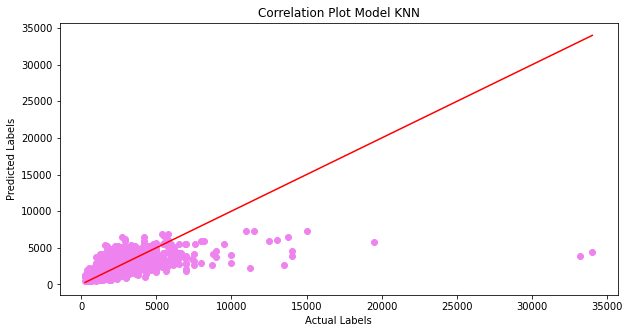

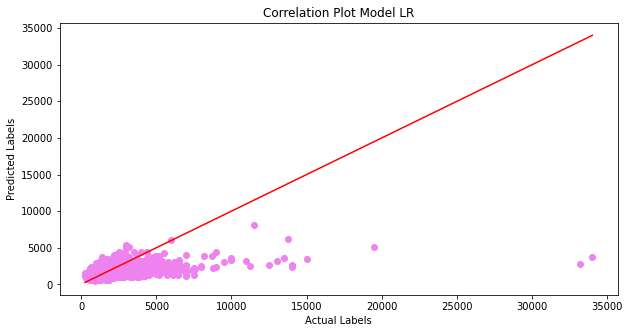

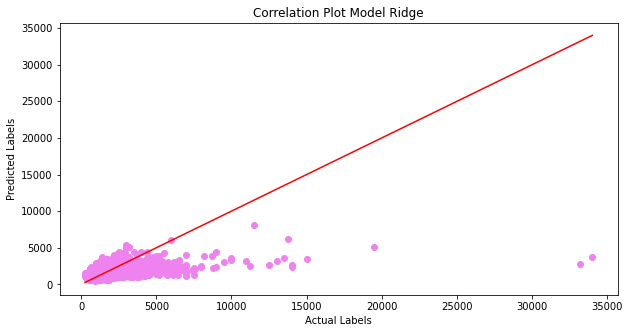

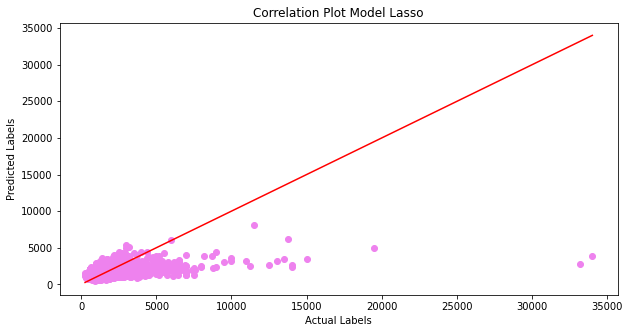

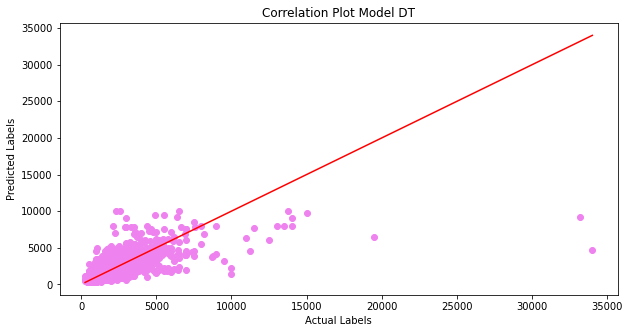

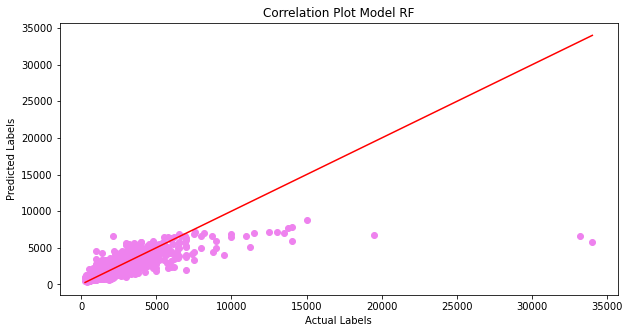

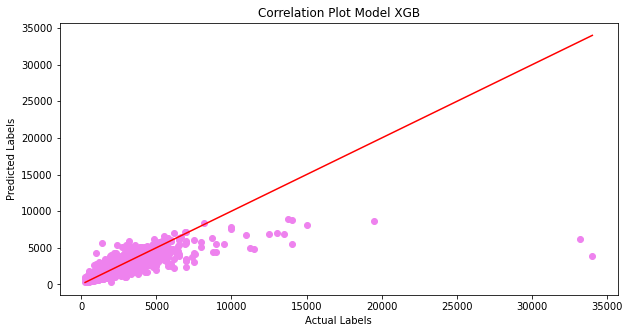

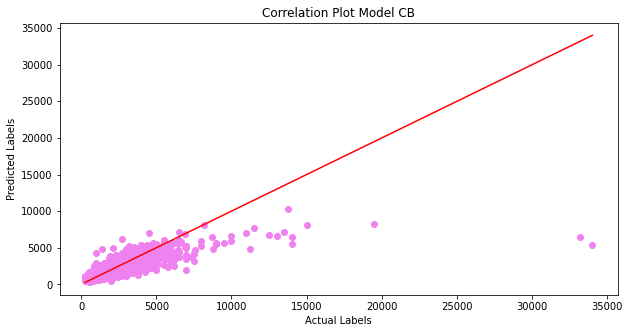

c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


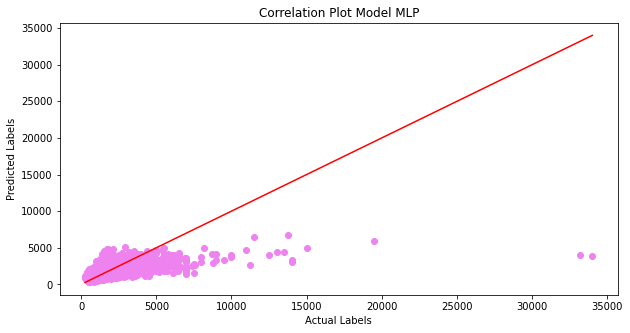

Epoch 1/50
310/310 [==============================] - 2s 3ms/step - loss: 1830093.7500 - mse: 1830093.7500
Epoch 2/50
310/310 [==============================] - 1s 4ms/step - loss: 415211.7500 - mse: 415211.7500
Epoch 3/50
310/310 [==============================] - 2s 5ms/step - loss: 369411.5312 - mse: 369411.5312
Epoch 4/50
310/310 [==============================] - 1s 3ms/step - loss: 352969.6562 - mse: 352969.6562
Epoch 5/50
310/310 [==============================] - 1s 3ms/step - loss: 343572.3125 - mse: 343572.3125
Epoch 6/50
310/310 [==============================] - 1s 3ms/step - loss: 336534.0938 - mse: 336534.0938
Epoch 7/50
310/310 [==============================] - 1s 3ms/step - loss: 331342.6562 - mse: 331342.6562
Epoch 8/50
310/310 [==============================] - 1s 3ms/step - loss: 326691.5938 - mse: 326691.5938
Epoch 9/50
310/310 [==============================] - 1s 3ms/step - loss: 322862.3750 - mse: 322862.3750
Epoch 10/50
310/310 [==============================] 

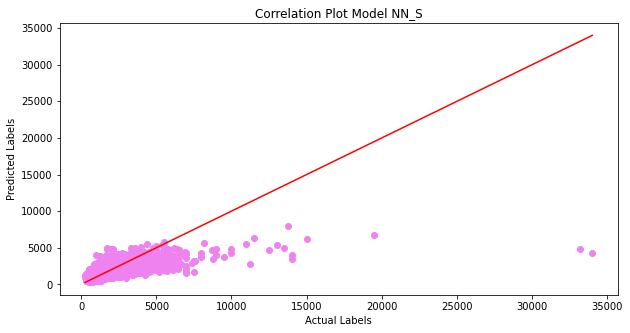

Epoch 1/50
310/310 [==============================] - 2s 5ms/step - loss: 989006.6250 - mse: 989006.6250
Epoch 2/50
310/310 [==============================] - 1s 5ms/step - loss: 346828.0625 - mse: 346828.0625
Epoch 3/50
310/310 [==============================] - 1s 5ms/step - loss: 336840.6875 - mse: 336840.6875
Epoch 4/50
310/310 [==============================] - 1s 5ms/step - loss: 331337.8750 - mse: 331337.8750
Epoch 5/50
310/310 [==============================] - 1s 4ms/step - loss: 328482.3750 - mse: 328482.3750
Epoch 6/50
310/310 [==============================] - 1s 4ms/step - loss: 325255.0000 - mse: 325255.0000
Epoch 7/50
310/310 [==============================] - 2s 5ms/step - loss: 320642.1875 - mse: 320642.1875
Epoch 8/50
310/310 [==============================] - 1s 4ms/step - loss: 312859.0938 - mse: 312859.0938
Epoch 9/50
310/310 [==============================] - 1s 5ms/step - loss: 304326.3125 - mse: 304326.3125
Epoch 10/50
310/310 [==============================] - 

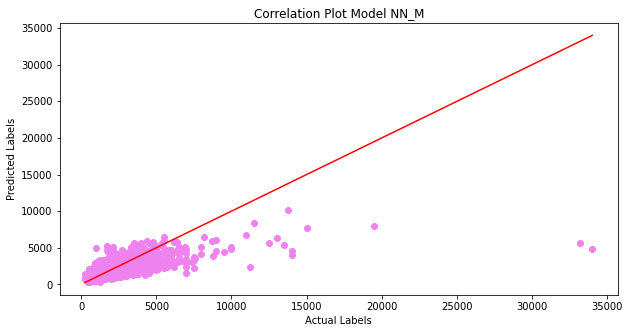

Epoch 1/50
310/310 [==============================] - 4s 10ms/step - loss: 740536.3750 - mse: 740536.3750
Epoch 2/50
310/310 [==============================] - 3s 9ms/step - loss: 337026.4062 - mse: 337026.4062
Epoch 3/50
310/310 [==============================] - 3s 10ms/step - loss: 330596.4688 - mse: 330596.4688
Epoch 4/50
310/310 [==============================] - 4s 12ms/step - loss: 326038.4062 - mse: 326038.4062
Epoch 5/50
310/310 [==============================] - 3s 11ms/step - loss: 316112.4062 - mse: 316112.4062
Epoch 6/50
310/310 [==============================] - 3s 9ms/step - loss: 305078.5312 - mse: 305078.5312
Epoch 7/50
310/310 [==============================] - 3s 10ms/step - loss: 290410.2500 - mse: 290410.2500
Epoch 8/50
310/310 [==============================] - 3s 10ms/step - loss: 276980.8750 - mse: 276980.8750
Epoch 9/50
310/310 [==============================] - 3s 10ms/step - loss: 265261.8125 - mse: 265261.8125
Epoch 10/50
310/310 [===========================

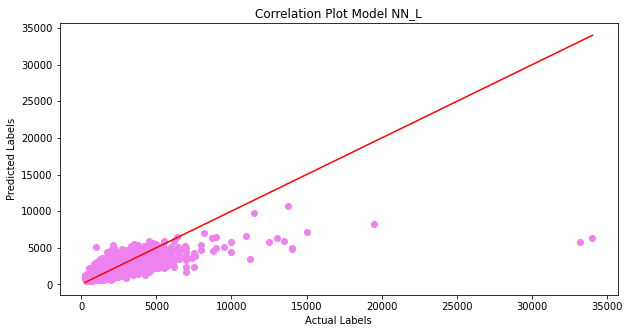

Epoch 1/50
310/310 [==============================] - 6s 13ms/step - loss: 2804282.5000 - mse: 2804282.5000
Epoch 2/50
310/310 [==============================] - 4s 14ms/step - loss: 2554383.0000 - mse: 2554383.0000
Epoch 3/50
310/310 [==============================] - 4s 12ms/step - loss: 2156987.0000 - mse: 2156987.0000
Epoch 4/50
310/310 [==============================] - 4s 13ms/step - loss: 1718463.6250 - mse: 1718463.6250
Epoch 5/50
310/310 [==============================] - 4s 13ms/step - loss: 1317798.0000 - mse: 1317798.0000
Epoch 6/50
310/310 [==============================] - 5s 15ms/step - loss: 964389.9375 - mse: 964389.9375
Epoch 7/50
310/310 [==============================] - 5s 15ms/step - loss: 668238.9375 - mse: 668238.9375
Epoch 8/50
310/310 [==============================] - 5s 17ms/step - loss: 448689.1875 - mse: 448689.1875
Epoch 9/50
310/310 [==============================] - 5s 15ms/step - loss: 312561.5938 - mse: 312561.5938
Epoch 10/50
310/310 [===============

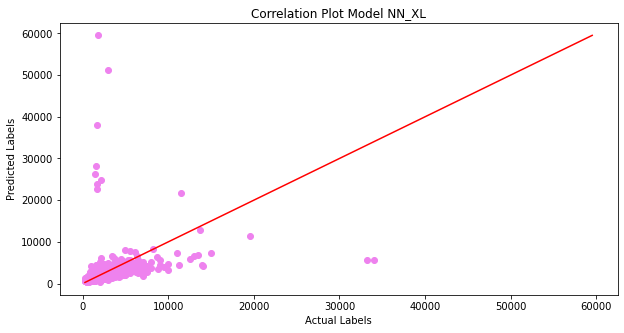

Epoch 1/50
310/310 [==============================] - 5s 12ms/step - loss: 2813605.2500 - mse: 2813605.2500
Epoch 2/50
310/310 [==============================] - 4s 14ms/step - loss: 2557661.5000 - mse: 2557661.5000
Epoch 3/50
310/310 [==============================] - 5s 15ms/step - loss: 2159834.7500 - mse: 2159834.7500
Epoch 4/50
310/310 [==============================] - 4s 13ms/step - loss: 1723277.5000 - mse: 1723277.5000
Epoch 5/50
310/310 [==============================] - 4s 14ms/step - loss: 1324224.8750 - mse: 1324224.8750
Epoch 6/50
310/310 [==============================] - 5s 16ms/step - loss: 971544.0000 - mse: 971544.0000
Epoch 7/50
310/310 [==============================] - 6s 18ms/step - loss: 670591.3750 - mse: 670591.3750
Epoch 8/50
310/310 [==============================] - 4s 12ms/step - loss: 454788.4375 - mse: 454788.4375
Epoch 9/50
310/310 [==============================] - 4s 12ms/step - loss: 315713.4375 - mse: 315713.4375
Epoch 10/50
310/310 [===============

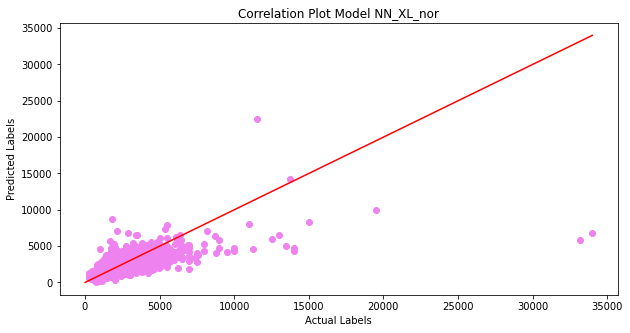

In [24]:
compares = {}
historys = {}
for name, model in models.items():
    # training
    start = time.time()
    if name in ['NN_S', 'NN_M', 'NN_L', 'NN_XL', 'NN_XL_nor']:
        history = model.fit(X_train, y_train, epochs=50, batch_size=256)
        historys[name] = history.history
        model.save(f'../model/no_outliers_threshold/{name}.h5')
    else:
        model.fit(X_train, y_train)
        # save model
        save_to_pickle_file(model, f'../model/no_outliers_threshold/{name}.pkl')
    time_train = time.time() - start

    # testing
    start = time.time()                 # thời gian bắt đầu
    y_pred = model.predict(X_test)      # dự đoán
    time_test = time.time() - start     # tính thời gian quá trình dự đoán

    if name in ['NN_S', 'NN_M', 'NN_L', 'NN_XL', 'NN_XL_nor']:
        y_pred = y_pred.flatten()
        
    # score
    AADP, SD, MSE, MAE, RMSE, R2 = caculate_score(y_test, y_pred)

    plot_evaluate(y_test, y_pred, name)
    # save compare
    compares[name] = {
        'time_train': time_train,
        'time_test': time_test,
        'y_pred': y_pred,
        'AADP': AADP,
        'SD': SD,
        'MSE': MSE,
        'RMSE': RMSE,
        'MAE': MAE,
        'R2': R2,
        }
save_to_pickle_file(compares, '../processor/no_outliers_threshold/compares.pkl')
save_to_pickle_file(historys, '../processor/no_outliers_threshold/historys.pkl')

In [25]:
pd.DataFrame(compares).T.drop('y_pred', axis=1
     ).style.highlight_min(color = 'red',axis = 0, subset=['time_train', 'time_test', 'AADP', 'SD', 'MSE', 'RMSE', 'MAE']
     ).highlight_max(color = 'green',axis = 0, subset=['R2'])

,time_train,time_test,AADP,SD,MSE,RMSE,MAE,R2
KNN,0.798006,1.499996,16.742349,563.564096,317926.383443,563.849611,257.952110,0.579637
LR,0.052014,0.000994,34.431279,767.844581,589640.780152,767.880707,477.994898,0.220376
Ridge,0.019976,0.001006,34.430853,767.846416,589643.540979,767.882505,477.983619,0.220372
Lasso,0.067997,0.002013,34.479671,768.592213,590787.186853,768.626819,478.420879,0.218860
DT,1.046003,0.016998,13.566215,520.695548,271125.551374,520.697178,210.618886,0.641517
RF,105.424488,1.395012,11.084939,439.307936,193000.162901,439.317838,169.197777,0.744815
XGB,9.586009,0.072989,14.395135,465.321557,216559.208578,465.359225,214.240149,0.713665
CB,20.435552,0.081000,15.347503,468.301830,219343.659665,468.341392,227.612216,0.709983
MLP,106.784165,0.033997,25.339847,655.793407,430130.893351,655.843650,369.914356,0.431280
NN_S,56.933003,1.601996,22.230973,604.651201,365603.846708,604.651839,328.617139,0.516598


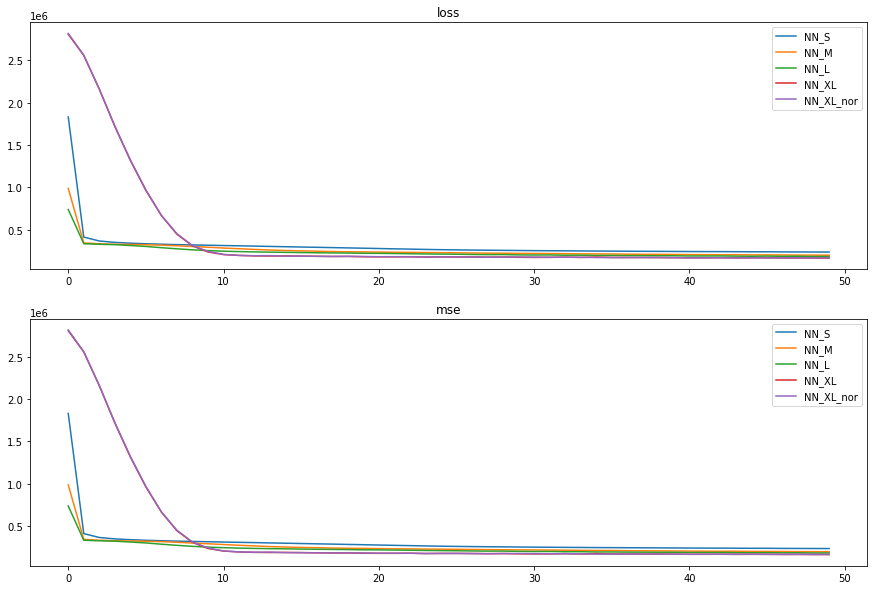

In [26]:
plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
plt.title('loss')
for name in historys.keys():
    plt.plot(historys[name]['loss'], label=f'{name}')
plt.legend()

plt.subplot(2,1,2)
plt.title('mse')
for name in historys.keys():
    plt.plot(historys[name]['mse'], label=f'{name}')
plt.legend()